In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.stats import ttest_1samp, ttest_ind, f_oneway, kruskal, bartlett

In [2]:
#importcreate_moving_windows to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46373 instead
  warnings.warn(


In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {'time':12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [4]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [5]:
ctrl = regrid_ACCESS(ctrl_sst)

In [6]:
%%time
ctrl = ctrl.compute()

CPU times: user 11.1 s, sys: 3.25 s, total: 14.3 s
Wall time: 2min 11s


In [7]:
#load observational SST
OBS = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/oisstv2.nc", chunks = {'time':12}).sst
#rename coords
OBS = OBS.rename({"lon": "longitude", "lat": "latitude"})
OBS = OBS.compute()

In [8]:
#load observational SST
ersstv5 = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ersstv5.nc", chunks = {'time':12}).sst
#rename coords
ersstv5 = ersstv5.rename({"lon": "longitude", "lat": "latitude"})
ersstv5 =ersstv5.sel(time = slice("1980-01-01", "2020-12-31"))
ersstv5 = ersstv5.compute()

In [9]:
ersstv5

<xarray.DataArray 'sst' (time: 492, latitude: 180, longitude: 360)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-12-01
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]

In [10]:
OBS

<xarray.DataArray 'sst' (time: 493, latitude: 180, longitude: 360)>
array([[[-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        ...,
...
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2022-12-01
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    standard_name:         sea_surface_temperature
    long_name:             Monthly Mean of Sea Surface Temperature
    units:                 degC
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    precision:             2
    var_desc:              Sea Surface Temperature
    dataset:               NOAA Optimum Interpolation (OI) SST V2
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    cell_methods:          time: mean (monthly from weekly values interpolate...

In [ ]:
#look at ENSO diversity

In [11]:
import random
import cftime

def select_random_windows(da, num_windows=10, len_window = 50):
    """
    Selects random 50-year windows from an xarray DataArray with monthly time steps.

    Args:
        da (xarray.DataArray): The data array to select windows from.
        num_windows (int): The number of windows to select.
        len_window (int): length of window in years

    Returns:
        A list of xarray DataArray objects, each containing a 50-year window of the original data.
    """
    windows = []
    start_year = da.time.dt.year.min().data
    end_year = da.time.dt.year.max().data - len_window
    for i in range(num_windows):
        start = random.randint(start_year, end_year)
        start_date = cftime.DatetimeGregorian(start, 1, 1)
        end_date = cftime.DatetimeGregorian(start + len_window, 12, 31)
        window = da.sel(time=slice(start_date, end_date))
        #window = window.std('time')
        windows.append(window)
    return windows

In [12]:
def create_moving_windows(da, len_window = 50):
    """
    Selects random 50-year windows from an xarray DataArray with monthly time steps.

    Args:
        da (xarray.DataArray): The data array to select windows from.
        num_windows (int): The number of windows to select.
        len_window (int): length of window in years

    Returns:
        A list of xarray DataArray objects, each containing a 50-year window of the original data.
    """
    windows = []
    start_year = da.time.dt.year.min().data
    end_year = da.time.dt.year.max().data - len_window
    for i in range(0, int(len(da.time)/12), 1):
        start_date = cftime.DatetimeGregorian(start_year, 1, 1)
        end_date = cftime.DatetimeGregorian(start_year + len_window, 12, 31)
        window = da.sel(time=slice(start_date, end_date))
        #window = window.std('time')
        windows.append(window)
        start_year = start_year+1

    return windows

In [13]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
     
def IOBM(DS):
    return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 100)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO-SETIO).drop('month')

In [14]:
def SH_mn(DS):
    return ssta(DS).sel(latitude=slice(-60, 0)).mean(['latitude', 'longitude'])
def NH_mn(DS):
    return ssta(DS).sel(latitude=slice(0, 60)).mean(['latitude', 'longitude'])

In [15]:
n34 = NINO34(ctrl)

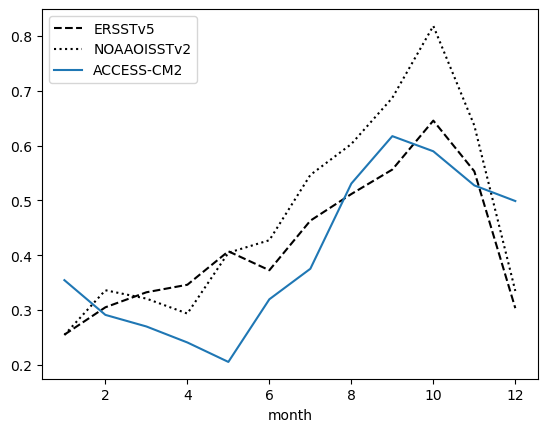

In [40]:
plt.figure()
dmi(ersstv5).groupby('time.month').std('time').plot(c = 'k', linestyle = '--', label = 'ERSSTv5')
dmi(OBS).groupby('time.month').std('time').plot(c = 'k', linestyle = ':', label = 'NOAAOISSTv2')

dmi(ctrl).groupby('time.month').std('time').plot(label = 'ACCESS-CM2')
plt.legend()

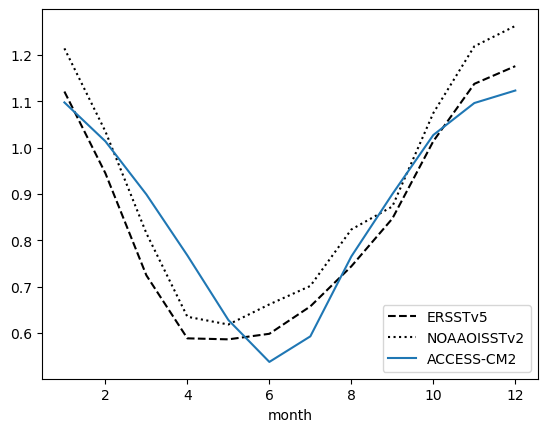

In [41]:
plt.figure()
NINO34(ersstv5).groupby('time.month').std('time').plot(c = 'k', linestyle = '--', label = 'ERSSTv5')
NINO34(OBS).groupby('time.month').std('time').plot(c = 'k', linestyle = ':', label = 'NOAAOISSTv2')

NINO34(ctrl).groupby('time.month').std('time').plot(label = 'ACCESS-CM2')
plt.legend()

In [42]:
from scipy.signal import welch

/local/e14/sm2435/tmp/ipykernel_252040/4289075663.py:7: RuntimeWarning: divide by zero encountered in divide
  period = 1 / freq / 12


([<matplotlib.axis.XTick at 0x7f1c64e21a90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

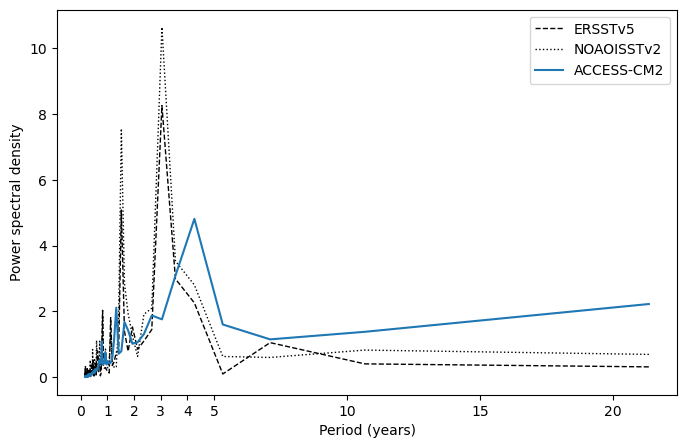

In [132]:
fs = 1 / (30.44 * 24 * 60 * 60)  # sampling frequency (in Hz)
freq, psd = welch(dmi(ersstv5), window='boxcar')
freq1, psd1 = welch(dmi(OBS), window='boxcar')
freq2, psd2 = welch(dmi(ctrl), window='boxcar')

# convert frequency to period (in years)
period = 1 / freq / 12

# plot the power spectral density with years on the x-axis
plt.figure(figsize=(8, 5))
plt.plot(period, psd, label = 'ERSSTv5',c = 'k', linestyle = '--', linewidth = 1)
plt.plot(period, psd1, label = 'NOAOISSTv2', c = 'k', linestyle = ':', linewidth = 1)
plt.plot(period, psd2, label = 'ACCESS-CM2')

plt.xlabel('Period (years)')
plt.ylabel('Power spectral density')
plt.legend()
plt.xticks([0,1,2,3,4,5,10,15,20])

/local/e14/sm2435/tmp/ipykernel_252040/2370777622.py:7: RuntimeWarning: divide by zero encountered in divide
  period = 1 / freq / 12


([<matplotlib.axis.XTick at 0x7f1c6514ce80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

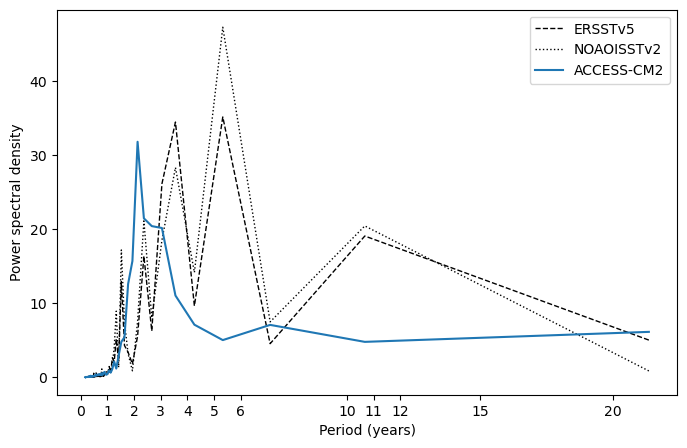

In [131]:
fs = 1 / (30.44 * 24 * 60 * 60)  # sampling frequency (in Hz)
freq, psd = welch(NINO34(ersstv5), window='boxcar')
freq1, psd1 = welch(NINO34(OBS), window='boxcar')
freq2, psd2 = welch(NINO34(ctrl), window='boxcar')

# convert frequency to period (in years)
period = 1 / freq / 12

# plot the power spectral density with years on the x-axis
plt.figure(figsize=(8, 5))
plt.plot(period, psd, label = 'ERSSTv5', c = 'k', linestyle = '--', linewidth = 1)
plt.plot(period, psd1, label = 'NOAOISSTv2', c = 'k', linestyle = ':', linewidth = 1) 
plt.plot(period, psd2, label = 'ACCESS-CM2')

plt.xlabel('Period (years)')
plt.ylabel('Power spectral density')
plt.legend()
plt.xticks([0,1,2,3,4,5,6,10,11,12,15,20])

In [110]:
period

array([        inf, 21.33333333, 10.66666667,  7.11111111,  5.33333333,
        4.26666667,  3.55555556,  3.04761905,  2.66666667,  2.37037037,
        2.13333333,  1.93939394,  1.77777778,  1.64102564,  1.52380952,
        1.42222222,  1.33333333,  1.25490196,  1.18518519,  1.12280702,
        1.06666667,  1.01587302,  0.96969697,  0.92753623,  0.88888889,
        0.85333333,  0.82051282,  0.79012346,  0.76190476,  0.73563218,
        0.71111111,  0.68817204,  0.66666667,  0.64646465,  0.62745098,
        0.60952381,  0.59259259,  0.57657658,  0.56140351,  0.54700855,
        0.53333333,  0.5203252 ,  0.50793651,  0.49612403,  0.48484848,
        0.47407407,  0.46376812,  0.45390071,  0.44444444,  0.43537415,
        0.42666667,  0.41830065,  0.41025641,  0.40251572,  0.39506173,
        0.38787879,  0.38095238,  0.37426901,  0.36781609,  0.36158192,
        0.35555556,  0.34972678,  0.34408602,  0.33862434,  0.33333333,
        0.32820513,  0.32323232,  0.31840796,  0.31372549,  0.30

Text(0.5, 0, 'Years/Cycle')

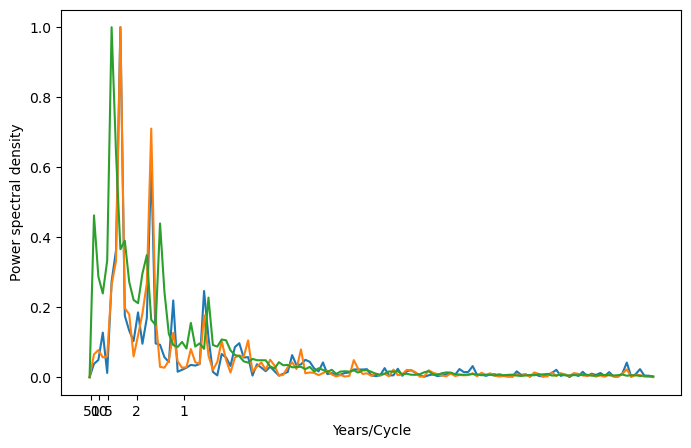

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(psd)
plt.plot(psd1)
plt.plot(psd2)

plt.xlabel('Period (years)')
plt.ylabel('Power spectral density')
ticks=[(1/(50*12))/freqs[1], (1/(10*12))/freqs[1], (1/(5*12))/freqs[1], (1/(2*12))/freqs[1], (1/12)/freqs[1]]
labels=[50,10,5,2,1]
plt.xticks(ticks, labels)
plt.xlabel('Years/Cycle')

/local/e14/sm2435/tmp/ipykernel_252040/2485682185.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(period, np.log10(freq), np.log10(psd), cmap='viridis')


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

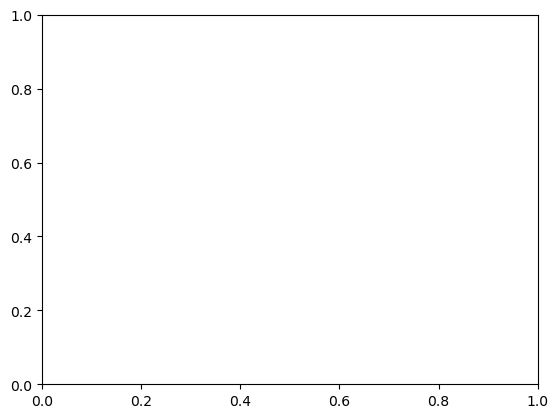

In [67]:
plt.pcolormesh(period, np.log10(freq), np.log10(psd), cmap='viridis')

In [17]:
ctrl_DMI = dmi(ctrl)

In [21]:
ctrl_DMI.groupby('time.month').std('time')

<xarray.DataArray (month: 12)>
array([0.3546015 , 0.29124007, 0.27009299, 0.24090621, 0.2054197 ,
       0.31971085, 0.37537968, 0.53082049, 0.61734653, 0.58971095,
       0.52745348, 0.49895719])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [43]:
SH = SH_mn(ctrl)

In [44]:
NH = NH_mn(ctrl)

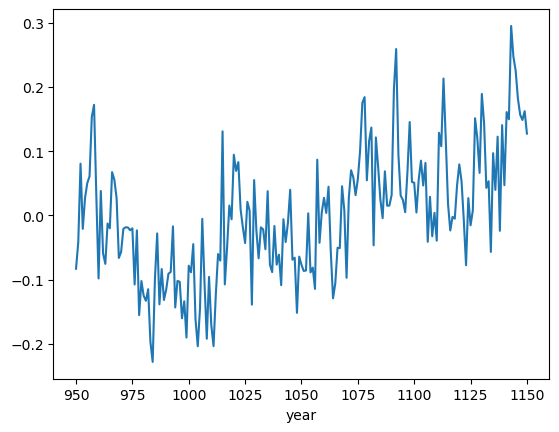

In [45]:
SH.groupby('time.year').mean('time').plot()

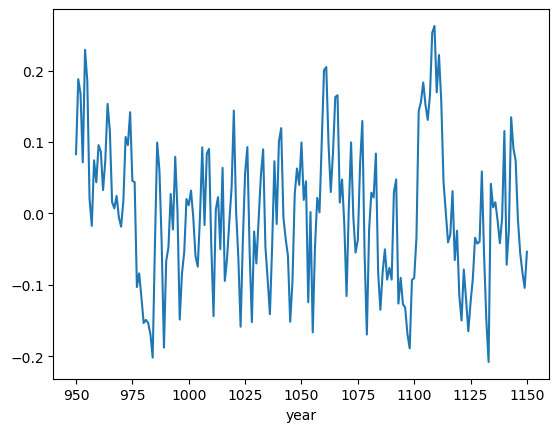

In [46]:
NH.groupby('time.year').mean('time').plot()

In [10]:
DMI = dmi(ctrl)

In [17]:
int(len(DMI.time)/12)

201

In [21]:
test = create_moving_windows(DMI, 50)

In [27]:
test1 = xr.concat(test, dim = 'window')

In [ ]:
test1.std('window')

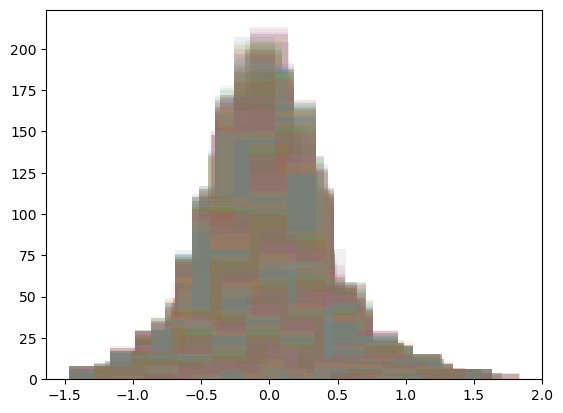

In [26]:
for i in test:
    i.plot.hist(alpha = 0.1)

In [76]:
def get_son(ds):
    return ds.sel(time=ds['time.month'].isin([9, 10, 11]))

In [118]:
DMI_son = get_son(DMI)

In [78]:
windows_10 = select_random_windows(DMI, num_windows=10, len_window=10)
windows_20 = select_random_windows(DMI, num_windows=10, len_window=20)
windows_30 = select_random_windows(DMI, num_windows=10, len_window=30)
windows_40 = select_random_windows(DMI, num_windows=10, len_window=40)
windows_50 = select_random_windows(DMI, num_windows=10, len_window=50)

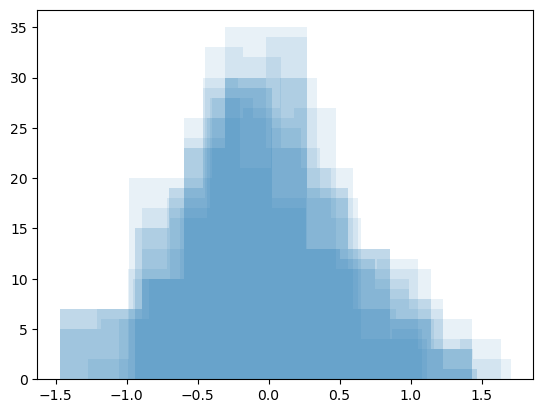

In [99]:
windows_50 = select_random_windows(DMI, num_windows=10, len_window=50)
for i in windows_50:
    i.plot.hist(alpha = 0.1, color = 'tab:blue')

In [102]:
windows_arr = xr.concat(windows_50, dim = 'win')

In [127]:
bartlett(windows_50[0], windows_50[1], windows_50[2], windows_50[3],windows_50[4],windows_50[5],windows_50[6],windows_50[7],windows_50[8],windows_50[9])

BartlettResult(statistic=23.519326164101678, pvalue=0.005129559864656668)

In [120]:
###just geta first 50 years and 2nd and 3rd
DMI_50 = DMI.sel(time=slice("0950-01-01", "0999-12-31"))
DMI_100 = DMI.sel(time=slice("1000-01-01", "1049-12-31"))
DMI_150 = DMI.sel(time=slice("1050-01-01", "1099-12-31"))
DMI_200 = DMI.sel(time=slice("1100-01-01", "1149-12-31"))

In [135]:
ttest_ind(DMI_150,DMI_200)

Ttest_indResult(statistic=1.320695023362329, pvalue=0.18685530434980172)

In [129]:
bartlett(DMI_50,DMI_100,DMI_150,DMI_200)

BartlettResult(statistic=24.24975765997051, pvalue=5.422905424355979e-06)

(array([  6.,  17.,  37., 106., 189., 156.,  44.,  26.,  13.,   6.]),
 array([-1.4688089 , -1.1668774 , -0.8649459 , -0.5630144 , -0.2610829 ,
         0.04084861,  0.3427801 ,  0.6447116 ,  0.9466431 ,  1.2485746 ,
         1.5505061 ], dtype=float32),
 <BarContainer object of 10 artists>)

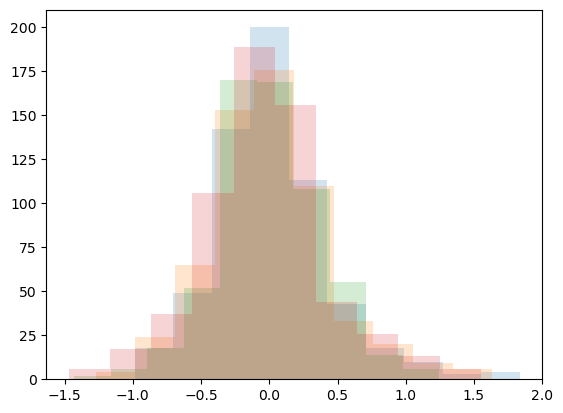

In [128]:
DMI_50.plot.hist(alpha = 0.2)
DMI_100.plot.hist(alpha = 0.2)
DMI_150.plot.hist(alpha = 0.2)
DMI_200.plot.hist(alpha = 0.2)